In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import keras
import tensorflow as tf

2024-03-07 12:56:13.207035: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 12:56:13.207131: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 12:56:13.338542: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Training Data Filepath
train_data = Path('/kaggle/input/face-expression-recognition-dataset/images/train')
train_data_list = list(train_data.glob(r'**/*.jpg'))
train_class_list = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], train_data_list))

# Testing Data Filepath
test_data_path = Path('/kaggle/input/face-expression-recognition-dataset/images/validation')
test_filepath_list = list(test_data_path.glob(r'**/*.jpg'))
test_class_list = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], test_filepath_list))

In [4]:
final_df = pd.DataFrame(columns = ['filepath', 'class', 'type'])

train_df = [{'filepath': str(filepath), 'class': class_, 'type': 'train'} for filepath, class_, in zip(train_data_list, train_class_list)]
test_df = [{'filepath': str(filepath), 'class': class_, 'type': 'test'} for filepath, class_, in zip(test_filepath_list, test_class_list)]

final_df = pd.concat([final_df, pd.DataFrame(train_df),pd.DataFrame(test_df)])

In [43]:
final_df.head()

,filepath,class,type
0,/kaggle/input/face-expression-recognition-data...,surprise,train
1,/kaggle/input/face-expression-recognition-data...,surprise,train
2,/kaggle/input/face-expression-recognition-data...,surprise,train
3,/kaggle/input/face-expression-recognition-data...,surprise,train
4,/kaggle/input/face-expression-recognition-data...,surprise,train


In [44]:
final_df['type'].value_counts()

type
train    28821
test      7066
Name: count, dtype: int64

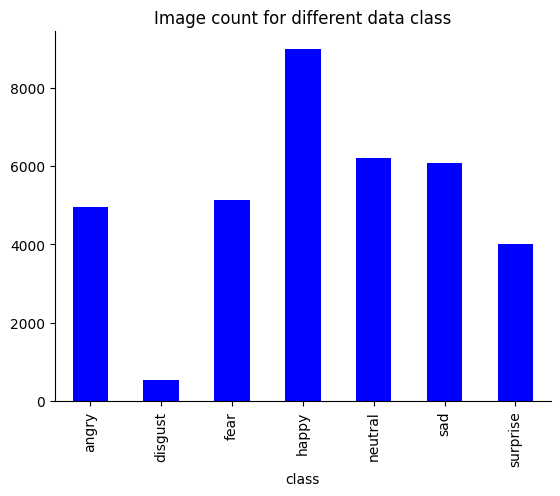

In [45]:
final_df.groupby('class').size().plot(kind='bar', color='blue')
plt.title('Image count for different data class')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [46]:
final_df[['class', 'type']].value_counts()

class     type 
happy     train    7164
neutral   train    4982
sad       train    4938
fear      train    4103
angry     train    3993
surprise  train    3205
happy     test     1825
neutral   test     1216
sad       test     1139
fear      test     1018
angry     test      960
surprise  test      797
disgust   train     436
          test      111
Name: count, dtype: int64

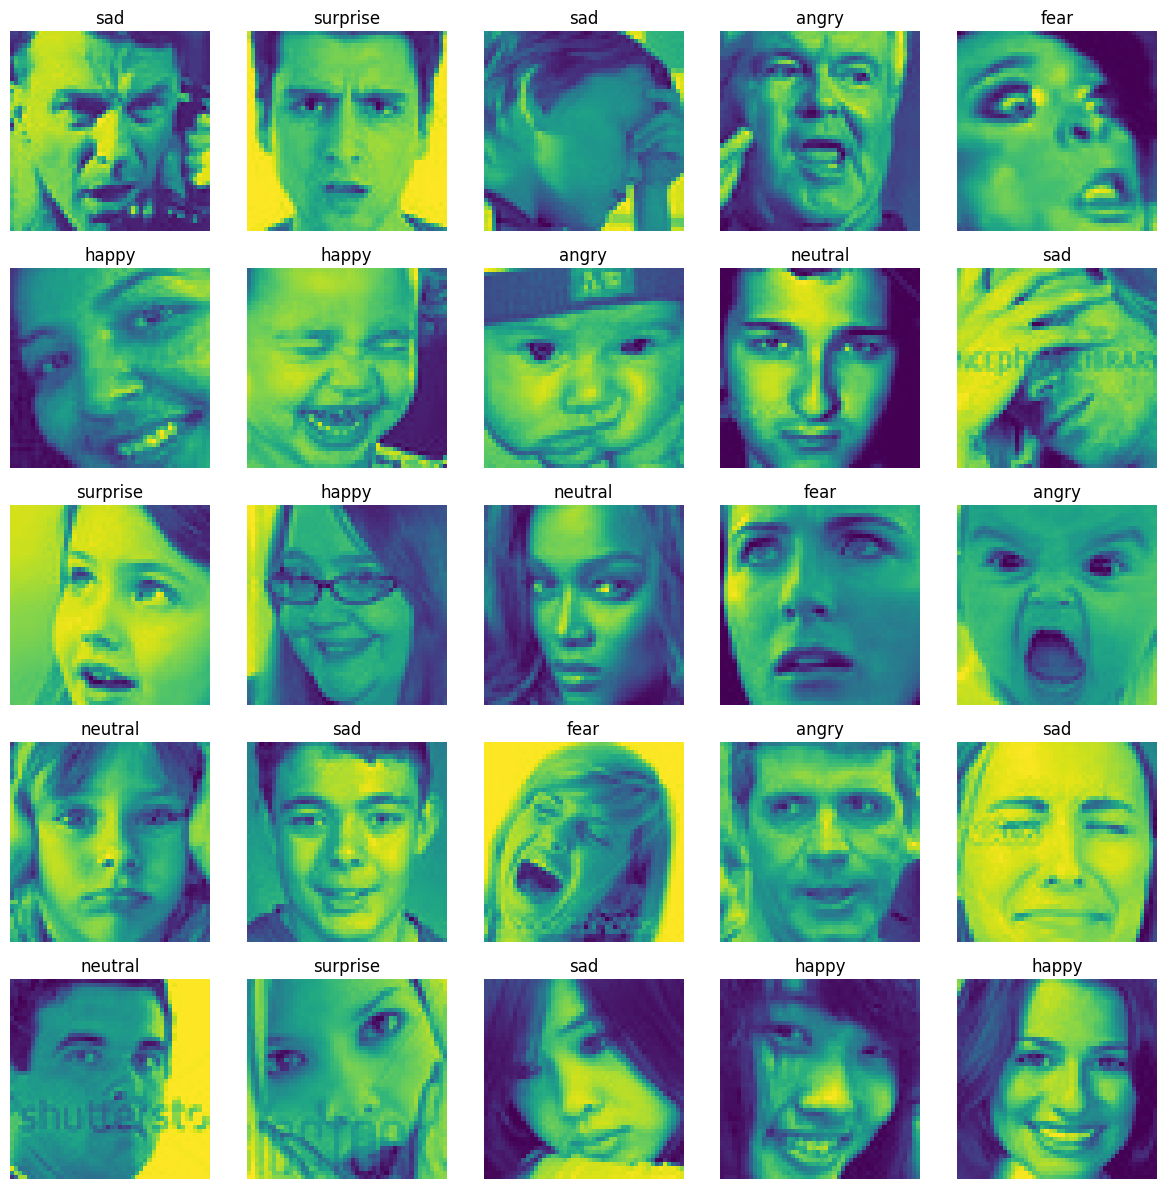

In [47]:
sample_df = final_df.sample(5 * 5, random_state=42)

# Create the figure and axes
fig, axes = plt.subplots(5, 5, figsize=(12, 12))

# Iterate over the axes and plot the images
for ax, img_path, title in zip(axes.flat, sample_df['filepath'], sample_df['class']):
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

# Show the figure
fig.tight_layout()
plt.show()

In [5]:
train_gen_instance = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1./255,
                             width_shift_range=0.2 ,
                             height_shift_range=0.2 ,
                             validation_split = 0.2,
                             zoom_range=0.2)
test_gen_instance = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [6]:
train_df = final_df[final_df['type']== 'train'].drop('type', axis = 1)
train_images = train_gen_instance.flow_from_dataframe(dataframe = train_df,
                                           x_col = 'filepath',
                                           y_col = 'class',
                                           target_size = (48,48),
                                           batch_size = 128,
                                          subset = 'training',
                                          color_mode="grayscale",
                                          class_mode='categorical')

valid_images = train_gen_instance.flow_from_dataframe(dataframe = train_df,
                                           x_col = 'filepath',
                                           y_col = 'class',
                                           target_size = (48,48),
                                           batch_size = 128,
                                           subset = 'validation',
                                          color_mode="grayscale",
                                          class_mode='categorical')


test_df = final_df[final_df['type']== 'test'].drop('type', axis = 1)
test_images = test_gen_instance.flow_from_dataframe(dataframe = test_df,
                                           x_col = 'filepath',
                                           y_col = 'class',
                                           target_size = (48,48),
                                           batch_size = 128,
                                          color_mode="grayscale",
                                          class_mode='categorical')

Found 23057 validated image filenames belonging to 7 classes.
Found 5764 validated image filenames belonging to 7 classes.
Found 7066 validated image filenames belonging to 7 classes.


In [31]:
def plot_training_results(history, title):
    plt.figure(figsize=(14, 8))
    plt.subplot(1,2,1)
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.plot(history.history['loss'], label='Training Loss', color = 'red')
    plt.title(title + ' Loss')


    plt.subplot(1,2,2)
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color = 'green')
    plt.title(title + ' Accuracy')
    plt.show()


In [21]:
# Initialising the CNN
cnn_model = keras.Sequential()

# 1 - Convolution
cnn_model.add(keras.layers.Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
cnn_model.add(keras.layers.BatchNormalization())
cnn_model.add(keras.layers.Activation('relu'))
cnn_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(keras.layers.Dropout(0.25))

# 2nd Convolution layer
cnn_model.add(keras.layers.Conv2D(128,(5,5), padding='same'))
cnn_model.add(keras.layers.BatchNormalization())
cnn_model.add(keras.layers.Activation('relu'))
cnn_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(keras.layers.Dropout(0.25))

# 3rd Convolution layer
cnn_model.add(keras.layers.Conv2D(512,(3,3), padding='same'))
cnn_model.add(keras.layers.BatchNormalization())
cnn_model.add(keras.layers.Activation('relu'))
cnn_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(keras.layers.Dropout(0.25))

# 4th Convolution layer
cnn_model.add(keras.layers.Conv2D(512,(3,3), padding='same'))
cnn_model.add(keras.layers.BatchNormalization())
cnn_model.add(keras.layers.Activation('relu'))
cnn_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(keras.layers.Dropout(0.25))

# Flattening
cnn_model.add(keras.layers.Flatten())

# Fully connected layer 1st layer
cnn_model.add(keras.layers.Dense(256))
cnn_model.add(keras.layers.BatchNormalization())
cnn_model.add(keras.layers.Activation('relu'))
cnn_model.add(keras.layers.Dropout(0.25))

# Fully connected layer 2nd layer
cnn_model.add(keras.layers.Dense(512))
cnn_model.add(keras.layers.BatchNormalization())
cnn_model.add(keras.layers.Activation('relu'))
cnn_model.add(keras.layers.Dropout(0.25))

cnn_model.add(keras.layers.Dense(7, activation='softmax'))

cnn_model.compile(optimizer="adam", 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

cnn_history = cnn_model.fit(train_images,
                            steps_per_epoch=train_images.n//train_images.batch_size,
                            epochs=10,
                            validation_data = valid_images,
                            validation_steps = valid_images.n//valid_images.batch_size,
                            )

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
  1/180 ━━━━━━━━━━━━━━━━━━━━ 59:41 20s/step - accuracy: 0.1875 - loss: 2.3990

I0000 00:00:1709817037.887489     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1709817037.915042     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.2663 - loss: 1.8408

W0000 00:00:1709817092.589130     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


180/180 ━━━━━━━━━━━━━━━━━━━━ 86s 369ms/step - accuracy: 0.2663 - loss: 1.8403 - val_accuracy: 0.0000e+00 - val_loss: 4.8223
Epoch 2/10
  1/180 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.2422 - loss: 1.6001

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2422 - loss: 1.6001 - val_accuracy: 0.0000e+00 - val_loss: 3.6934
Epoch 3/10


W0000 00:00:1709817104.869174     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


180/180 ━━━━━━━━━━━━━━━━━━━━ 39s 212ms/step - accuracy: 0.2884 - loss: 1.6580 - val_accuracy: 0.0000e+00 - val_loss: 5.8827
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 82us/step - accuracy: 0.2891 - loss: 1.6175 - val_accuracy: 0.0000e+00 - val_loss: 5.6505
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 39s 210ms/step - accuracy: 0.3137 - loss: 1.6002 - val_accuracy: 0.0000e+00 - val_loss: 6.4259
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 84us/step - accuracy: 0.3594 - loss: 1.5162 - val_accuracy: 0.0000e+00 - val_loss: 7.4524
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 37s 196ms/step - accuracy: 0.3533 - loss: 1.5522 - val_accuracy: 0.0000e+00 - val_loss: 7.1714
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 79us/step - accuracy: 0.3281 - loss: 1.5432 - val_accuracy: 0.0000e+00 - val_loss: 8.4747
Epoch 9/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 35s 191ms/step - accuracy: 0.4111 - loss: 1.4443 - val_accuracy: 0.0000e+00 - val_loss: 8.6623
Epoch 10/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 85us/step - accuracy: 0.4375

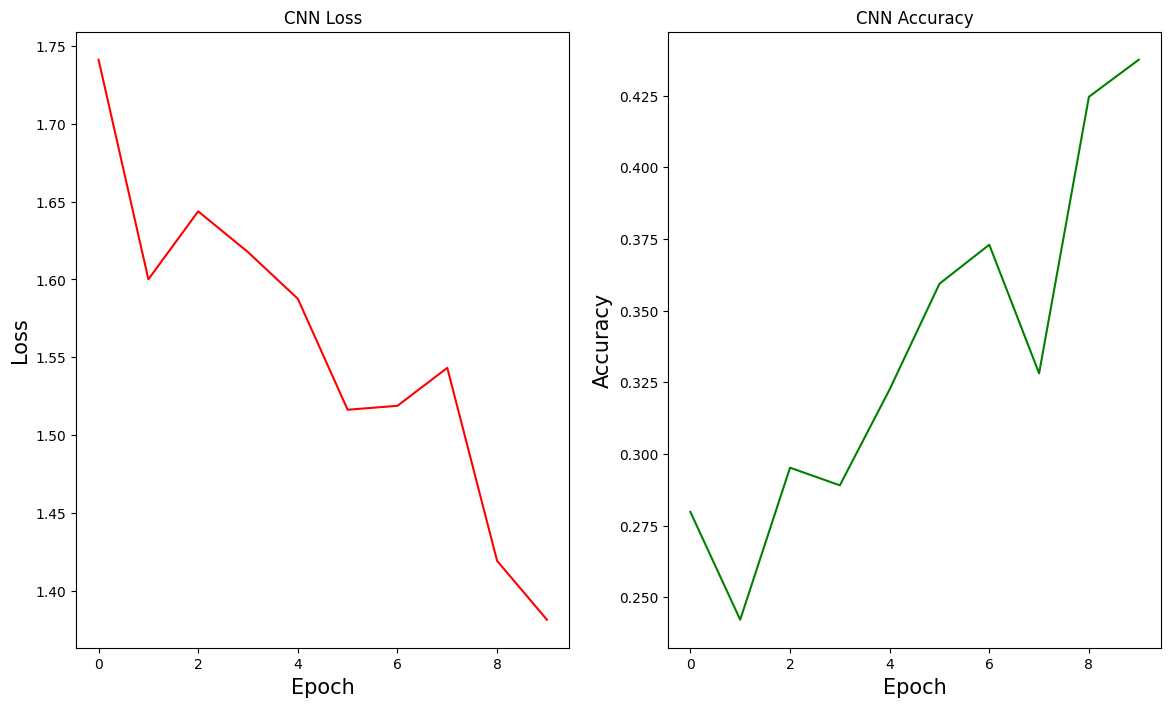

In [32]:
plot_training_results(cnn_history, 'CNN')

In [33]:
lstm_model = keras.Sequential()

lstm_model.add(keras.layers.Conv2D(64, (3,3), padding="same", 
                                  input_shape=(48,48, 1)))
lstm_model.add(keras.layers.BatchNormalization())
lstm_model.add(keras.layers.Activation('relu'))
lstm_model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
lstm_model.add(keras.layers.Dropout(0.25))

lstm_model.add(keras.layers.Conv2D(128, (5,5), padding="same"))
lstm_model.add(keras.layers.BatchNormalization())
lstm_model.add(keras.layers.Activation('relu'))
lstm_model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
lstm_model.add(keras.layers.Dropout(0.25))

lstm_model.add(keras.layers.Conv2D(512, (3,3), padding="same"))
lstm_model.add(keras.layers.BatchNormalization())
lstm_model.add(keras.layers.Activation('relu'))
lstm_model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
lstm_model.add(keras.layers.Dropout(0.25))

lstm_model.add(keras.layers.Conv2D(512, (3,3), padding="same"))
lstm_model.add(keras.layers.BatchNormalization())
lstm_model.add(keras.layers.Activation('relu'))
lstm_model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
lstm_model.add(keras.layers.Dropout(0.25))

lstm_model.add(tf.keras.layers.Reshape((9, 512)))  
lstm_model.add(tf.keras.layers.LSTM(64))                              

  
lstm_model.add(keras.layers.Dense(7, activation='softmax'))
          
lstm_model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

lstm_history = lstm_model.fit(train_images,
                            steps_per_epoch=train_images.n//train_images.batch_size,
                            epochs=10,
                            validation_data = valid_images,
                            validation_steps = valid_images.n//valid_images.batch_size,
                            )

Epoch 1/10


2024-03-07 13:16:53.799002: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_3_1/dropout_10_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - accuracy: 0.3083 - loss: 1.6033 - val_accuracy: 0.0000e+00 - val_loss: 4.8727
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - accuracy: 0.3047 - loss: 0.8093 - val_accuracy: 0.0000e+00 - val_loss: 1.8737
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 37s 201ms/step - accuracy: 0.3370 - loss: 1.5470 - val_accuracy: 0.0000e+00 - val_loss: 5.1468
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 131us/step - accuracy: 0.3438 - loss: 0.7669 - val_accuracy: 0.0000e+00 - val_loss: 2.4271
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.3846 - loss: 1.4707 - val_accuracy: 0.0000e+00 - val_loss: 5.9346
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 131us/step - accuracy: 0.4141 - loss: 0.6878 - val_accuracy: 0.0000e+00 - val_loss: 3.0520
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.4429 - loss: 1.3766 - val_accuracy: 0.0000e+00 - val_loss: 5.8442
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 133us/step - accuracy: 0.5

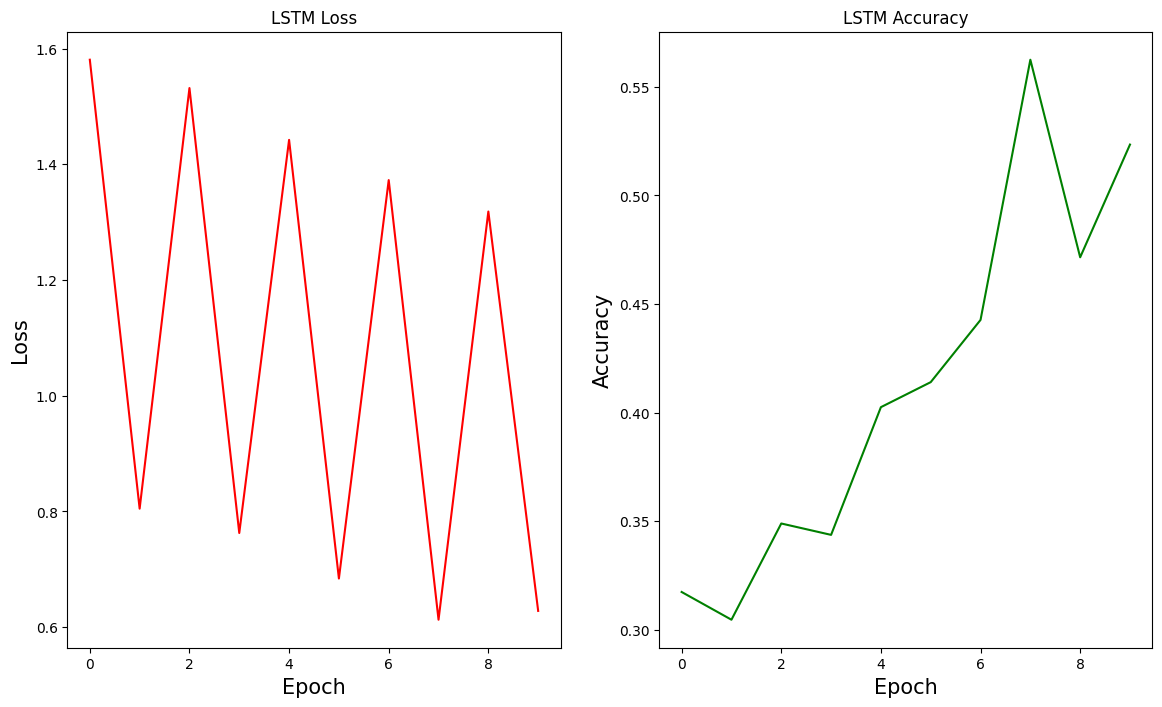

In [34]:
plot_training_results(lstm_history, 'LSTM')

In [41]:
dnn_model = keras.Sequential()

dnn_model.add(keras.layers.Dense(128, activation='relu'))
dnn_model.add(keras.layers.BatchNormalization())
dnn_model.add(keras.layers.Dropout(0.25))

dnn_model.add(keras.layers.Dense(128, activation='relu'))
dnn_model.add(keras.layers.BatchNormalization())
dnn_model.add(keras.layers.Dropout(0.27))

dnn_model.add(keras.layers.Dense(256, activation='relu'))
dnn_model.add(keras.layers.BatchNormalization())
dnn_model.add(keras.layers.Dropout(0.3))

dnn_model.add(keras.layers.Dense(128, activation='relu'))
dnn_model.add(keras.layers.BatchNormalization())
dnn_model.add(keras.layers.Dropout(0.27))

dnn_model.add(keras.layers.Dense(256, activation='relu'))
dnn_model.add(keras.layers.BatchNormalization())
dnn_model.add(keras.layers.Dropout(0.25))

dnn_model.add(keras.layers.Flatten())


dnn_model.add(keras.layers.Dense(7, activation='softmax'))


dnn_model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

dnn_history = dnn_model.fit(train_images,
                            steps_per_epoch=train_images.n//train_images.batch_size,
                            epochs=10,
                            validation_data = valid_images,
                            validation_steps = valid_images.n//valid_images.batch_size,
                            )

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 85s 376ms/step - accuracy: 0.2145 - loss: 10.5269 - val_accuracy: 0.0000e+00 - val_loss: 28.2034
Epoch 2/10
  1/180 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.2109 - loss: 16.8247

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2109 - loss: 16.8247 - val_accuracy: 0.0000e+00 - val_loss: 35.3864
Epoch 3/10


W0000 00:00:1709822272.989487     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


180/180 ━━━━━━━━━━━━━━━━━━━━ 36s 196ms/step - accuracy: 0.2374 - loss: 15.9241 - val_accuracy: 0.0203 - val_loss: 27.0303
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 121us/step - accuracy: 0.2344 - loss: 14.6512 - val_accuracy: 0.0000e+00 - val_loss: 30.3991
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 37s 199ms/step - accuracy: 0.2370 - loss: 16.0493 - val_accuracy: 0.0703 - val_loss: 23.6326
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 120us/step - accuracy: 0.2266 - loss: 14.3176 - val_accuracy: 0.0000e+00 - val_loss: 19.2441
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.2407 - loss: 13.8423 - val_accuracy: 0.0247 - val_loss: 24.1452
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 137us/step - accuracy: 0.2656 - loss: 11.0088 - val_accuracy: 0.0000e+00 - val_loss: 17.2489
Epoch 9/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 39s 211ms/step - accuracy: 0.2429 - loss: 10.9116 - val_accuracy: 0.0064 - val_loss: 18.7847
Epoch 10/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 126us/step - accuracy: 0.24

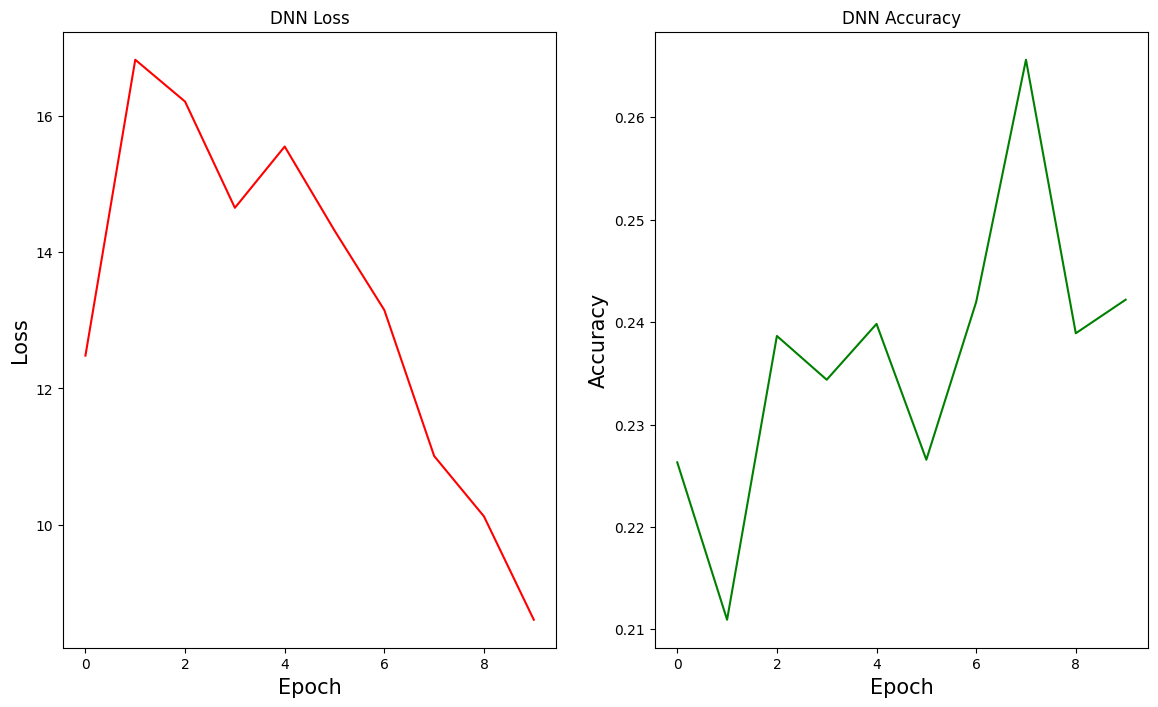

In [42]:
plot_training_results(dnn_history, 'DNN')